In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, EfficientNetB4

import warnings
warnings.filterwarnings('ignore')

In [4]:
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=5,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
)

In [5]:
train_ds = img_datagen.flow_from_directory(
    '../Paddy Disease Classification/paddy-disease-classification/train_images',
    subset='training',
    class_mode='categorical',
    batch_size=16,
    target_size=(128, 128)
)

val_ds = img_datagen.flow_from_directory(
    '../Paddy Disease Classification/paddy-disease-classification/train_images',
    subset='validation',
    class_mode='categorical',
    batch_size=64,
    target_size=(128, 128)
)

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.


In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 128, 128, 3)
(16, 10)


In [10]:
labels_batch[:16]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

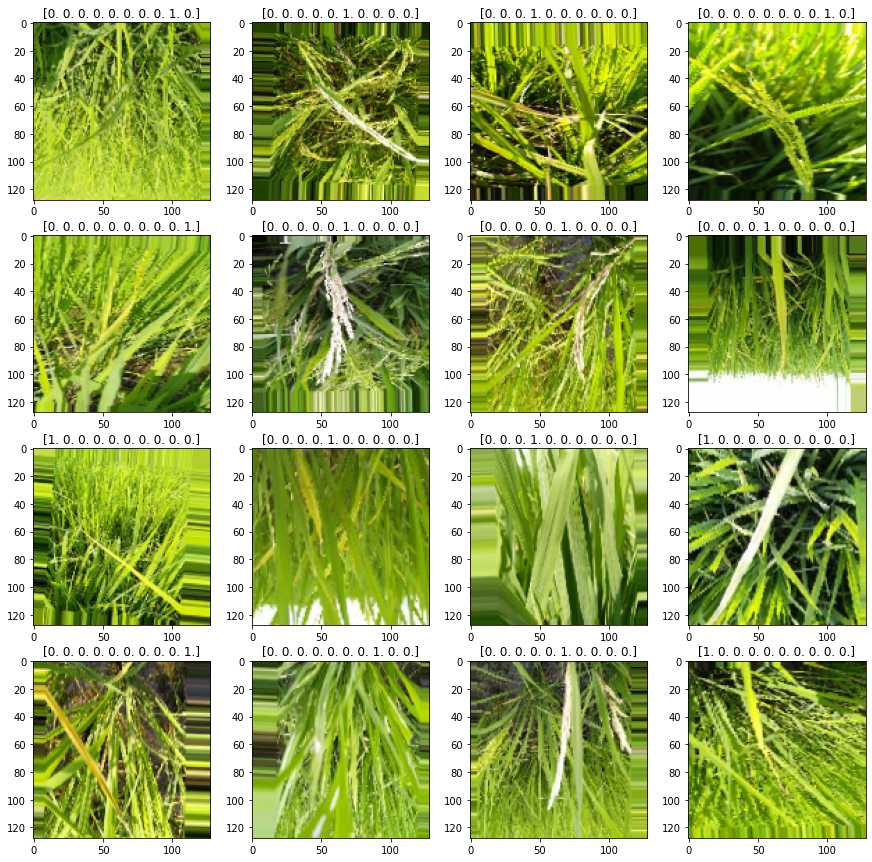

In [11]:
cnt = 0
plt.figure(figsize=(15, 15))
for i in range(0, 16):
    plt.subplot(4, 4, cnt + 1)
    plt.imshow(image_batch[cnt])
    plt.title(labels_batch[cnt])
    cnt += 1
plt.show()

In [12]:
image_batch, labels_batch = next(iter(train_ds))
image_batch[0]

array([[[3.78029764e-01, 4.53334540e-01, 1.08615845e-01],
        [3.65285605e-01, 4.56689179e-01, 2.16677040e-02],
        [3.67923021e-01, 4.56876189e-01, 1.63281534e-03],
        ...,
        [2.67774880e-01, 3.86935711e-01, 3.69097781e-03],
        [2.54581779e-01, 3.77230883e-01, 0.00000000e+00],
        [2.54379362e-01, 3.81335944e-01, 0.00000000e+00]],

       [[7.09829271e-01, 7.77242184e-01, 4.58806157e-02],
        [6.92454278e-01, 7.62135506e-01, 2.18078345e-02],
        [6.65960193e-01, 7.43797004e-01, 4.94605023e-03],
        ...,
        [2.68714994e-01, 3.87458950e-01, 1.38547010e-04],
        [2.65885741e-01, 3.83868128e-01, 0.00000000e+00],
        [2.63980210e-01, 3.82482082e-01, 0.00000000e+00]],

       [[8.63956869e-01, 9.28399801e-01, 1.25156669e-02],
        [8.58035624e-01, 9.23642933e-01, 1.29243694e-02],
        [8.47874701e-01, 9.22448039e-01, 6.36924524e-03],
        ...,
        [2.68647194e-01, 3.86559606e-01, 0.00000000e+00],
        [2.66666681e-01, 3.84

In [13]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(128, 128, 3),
    include_top=False
)
base_model.trainable = False

83683744/83683744 [==============================] - 2s 0us/step


In [16]:
model = tf.keras.Sequential()

model.add(base_model)
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(
    128, (3, 3),
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.L2(0.001)
))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(
    256,
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.L2(0.001)
))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(
    256,
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.L2(0.001)
))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 batch_normalization_6 (Batc  (None, 4, 4, 2048)       8192      
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 2, 2, 128)         2359424   
                                                                 
 dropout_4 (Dropout)         (None, 2, 2, 128)         0         
                                                                 
 global_average_pooling2d_1   (None, 128)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
lr_shceduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=10,
    vergbose=1
)

save_best = tf.keras.callbacks.ModelCheckpoint(
    'Model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [20]:
%%time

model = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[save_best]
)

Epoch 1/5
521/521 [==============================] - ETA: 0s - loss: 4.2654 - accuracy: 0.1427
Epoch 1: val_accuracy improved from -inf to 0.16851, saving model to Model.h5
521/521 [==============================] - 40s 70ms/step - loss: 4.2654 - accuracy: 0.1427 - val_loss: 3.1658 - val_accuracy: 0.1685
Epoch 2/5
521/521 [==============================] - ETA: 0s - loss: 3.1926 - accuracy: 0.1616
Epoch 2: val_accuracy improved from 0.16851 to 0.19403, saving model to Model.h5
521/521 [==============================] - 35s 67ms/step - loss: 3.1926 - accuracy: 0.1616 - val_loss: 3.0810 - val_accuracy: 0.1940
Epoch 3/5
521/521 [==============================] - ETA: 0s - loss: 3.0356 - accuracy: 0.1693
Epoch 3: val_accuracy improved from 0.19403 to 0.20703, saving model to Model.h5
521/521 [==============================] - 35s 67ms/step - loss: 3.0356 - accuracy: 0.1693 - val_loss: 2.9411 - val_accuracy: 0.2070
Epoch 4/5
521/521 [==============================] - ETA: 0s - loss: 2.8826 

In [21]:
model.history

{'loss': [4.265417575836182,
  3.1926321983337402,
  3.0355660915374756,
  2.8826262950897217,
  2.7430973052978516],
 'accuracy': [0.14273709058761597,
  0.16158463060855865,
  0.1692677140235901,
  0.16974790394306183,
  0.186794713139534],
 'val_loss': [3.1658096313476562,
  3.0810024738311768,
  2.9410805702209473,
  2.8026208877563477,
  2.6800222396850586],
 'val_accuracy': [0.1685122847557068,
  0.19402985274791718,
  0.20702937245368958,
  0.1781415492296219,
  0.1853635013103485]}

In [22]:
model = tf.keras.models.load_model('./Model.h5')

In [23]:
model.evaluate(val_ds)

33/33 [==============================] - 7s 206ms/step - loss: 2.9454 - accuracy: 0.1979


[2.9454345703125, 0.1978815644979477]

In [24]:
test_path = '../Paddy Disease Classification/paddy-disease-classification/test_images'
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=test_path,
    target_size=(128, 128),
    batch_size=16,
    classes=['.'],
    shuffle=False
)

Found 3469 images belonging to 1 classes.


In [25]:
predict = model.predict(test_gen, verbose=1)

217/217 [==============================] - 11s 49ms/step


In [28]:
predicted_class_indices = np.argmax(predict, axis=1)
print(set(predicted_class_indices))

inv_map = {v: k for k, v in train_ds.class_indices.items()}
predictions = [inv_map[k] for k in predicted_class_indices]

{8, 3, 5, 7}


In [38]:
filenames = test_gen.filenames

results = pd.DataFrame({
    'image_id': filenames,
    'label': predictions
})
results.image_id = results.image_id.str.replace(r'.*\\', '')
results.to_csv('submission.csv', index=False)
results

,image_id,label
0,200001.jpg,blast
1,200002.jpg,blast
2,200003.jpg,hispa
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,blast
3465,203466.jpg,dead_heart
3466,203467.jpg,blast
3467,203468.jpg,blast


In [34]:
results['label'].value_counts()

blast         2922
hispa          267
dead_heart     229
normal          51
Name: label, dtype: int64